<a href="https://colab.research.google.com/github/tatamiya/blog_artifacts/blob/main/zenn/20231216_spike_and_slab/Spike_and_Slab%E5%9B%9E%E5%B8%B0%E3%82%92PyMC%E3%81%A7%E8%A9%A6%E3%81%97%E3%81%A6%E3%81%BF%E3%82%8B%EF%BC%88%E5%AE%8C%E6%88%90%E7%A8%BF%E7%94%A8%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# この notebook は？


Spike-and-Slab 事前分布を用いた線形回帰の類似実装を PyMC で行い、同事前分布を用いない場合・最小二乗法により推定した場合との比較を行った。

以下の記事を参考に適宜修正を加えた。

http://www.batisengul.co.uk/post/spike-and-slab-bayesian-linear-regression-with-variable-selection/

In [1]:
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
pm.__version__

'5.7.2'

# サンプルデータの生成

In [3]:
n_samples = 16

x_min = 0.0
x_max = 8.0

x = x_min + (x_max - x_min) * np.arange(0, n_samples+1, 1) / n_samples
x

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. ])

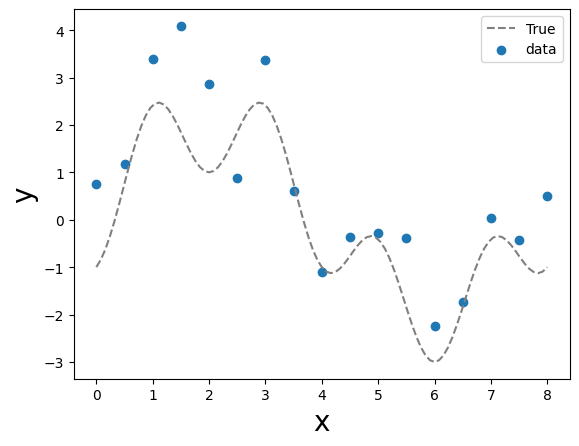

In [4]:
np.random.seed(0)

sigma = 1.0
sigma2 = sigma **2

#true_beta = np.array([2, 1.0, 0.5, -0.5, -1.5, -1.0])
true_beta = np.array([2, 0.0, 0.0, 0.0, 0.0, -1.0])

def generate_design_matrix(x):
  return np.array([
      #np.ones(x.shape[0]), ## 今回は定数項入れない
      np.sin(2 * np.pi / 8 * x), np.cos(2 * np.pi / 8 * x),
      np.sin(2 * 2 * np.pi / 8 * x), np.cos(2 * 2 * np.pi / 8 * x),
      np.sin(4 * 2 * np.pi / 8 * x), np.cos(4 * 2 * np.pi / 8 * x)
      ]).T

y =  generate_design_matrix(x) @ true_beta + sigma * np.random.randn(x.shape[0])

x_sample = x_min + (x_max - x_min) * np.arange(0, 101, 1) / 100
y_org_sample = generate_design_matrix(x_sample) @ true_beta

fig, ax = plt.subplots()
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.scatter(x, y, label="data")
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("y", fontsize=20)
ax.legend(loc="best")

In [5]:
# 計画行列の生成
x_des = generate_design_matrix(x)

# Spike-and-Slab 線形回帰モデルの作成

## モデル定義

In [6]:
# モデルの定義
## 下記の記事のコードをベースにした。
## http://www.batisengul.co.uk/post/spike-and-slab-bayesian-linear-regression-with-variable-selection/

## 事前分布およびそのハイパーパラメータは、下記の論文を参考にした
## Brodersen, Kay H., Fabian Gallusser, Jim Koehler, Nicolas Remy, and Steven L. Scott. "Inferring causal impact using Bayesian structural time-series models." (2015): 247-274.
## Scott, Steven L., and Hal R. Varian. "Predicting the present with Bayesian structural time series." International Journal of Mathematical Modelling and Numerical Optimisation 5, no. 1-2 (2014): 4-23.

def get_model(y, X):
    n = y.shape[0]
    p = X.shape[1]

    model = pm.Model()

    Sigma = 0.5 * np.matmul(X.T, X) / n
    Sigma += np.diag(np.diag(Sigma))

    s_y2 = np.var(y, ddof=1)

    nu = 0.01
    R2 = 0.5
    s = nu * (1 - R2) * s_y2

    with model:
        rho = pm.Bernoulli('rho', .5, shape=p)

        tau = pm.Gamma('tau', nu/2, s/2)

        # CausalImpact で用いられている実装と異なり、本実装では rho[k]=0 に対応する回帰係数を除外せず、代わりに0を中心に局在した事前分布を割り当てる。
        restricted_Sigma = pt.diag(rho) * Sigma * pt.diag(rho) + n **2 * (pt.identity_like(Sigma) - pt.diag(rho)) * np.diag(np.diag(Sigma))
        beta = pm.MvNormal('beta', 0, tau=tau * restricted_Sigma, shape=p)
        #restrict_mat = pt.diag(rho) + n * (pt.identity_like(Sigma) - pt.diag(rho))
        #beta = pm.MvNormal('beta', 0, tau=tau * restrict_mat * Sigma * restrict_mat, shape=p)
        #beta = pm.MvNormal('beta', 0, tau=tau * Sigma, shape=X.shape[1])
        mean = pm.math.dot(X, beta)
        #mean = pm.math.dot(X, rho * beta)
        y_obs = pm.Normal('y_obs', mean, tau=tau, observed=y)
    return model

In [7]:
model = get_model(y, x_des)

with model:
    # draw 1000 posterior samples
    idata = pm.sample()

## 事後分布の可視化

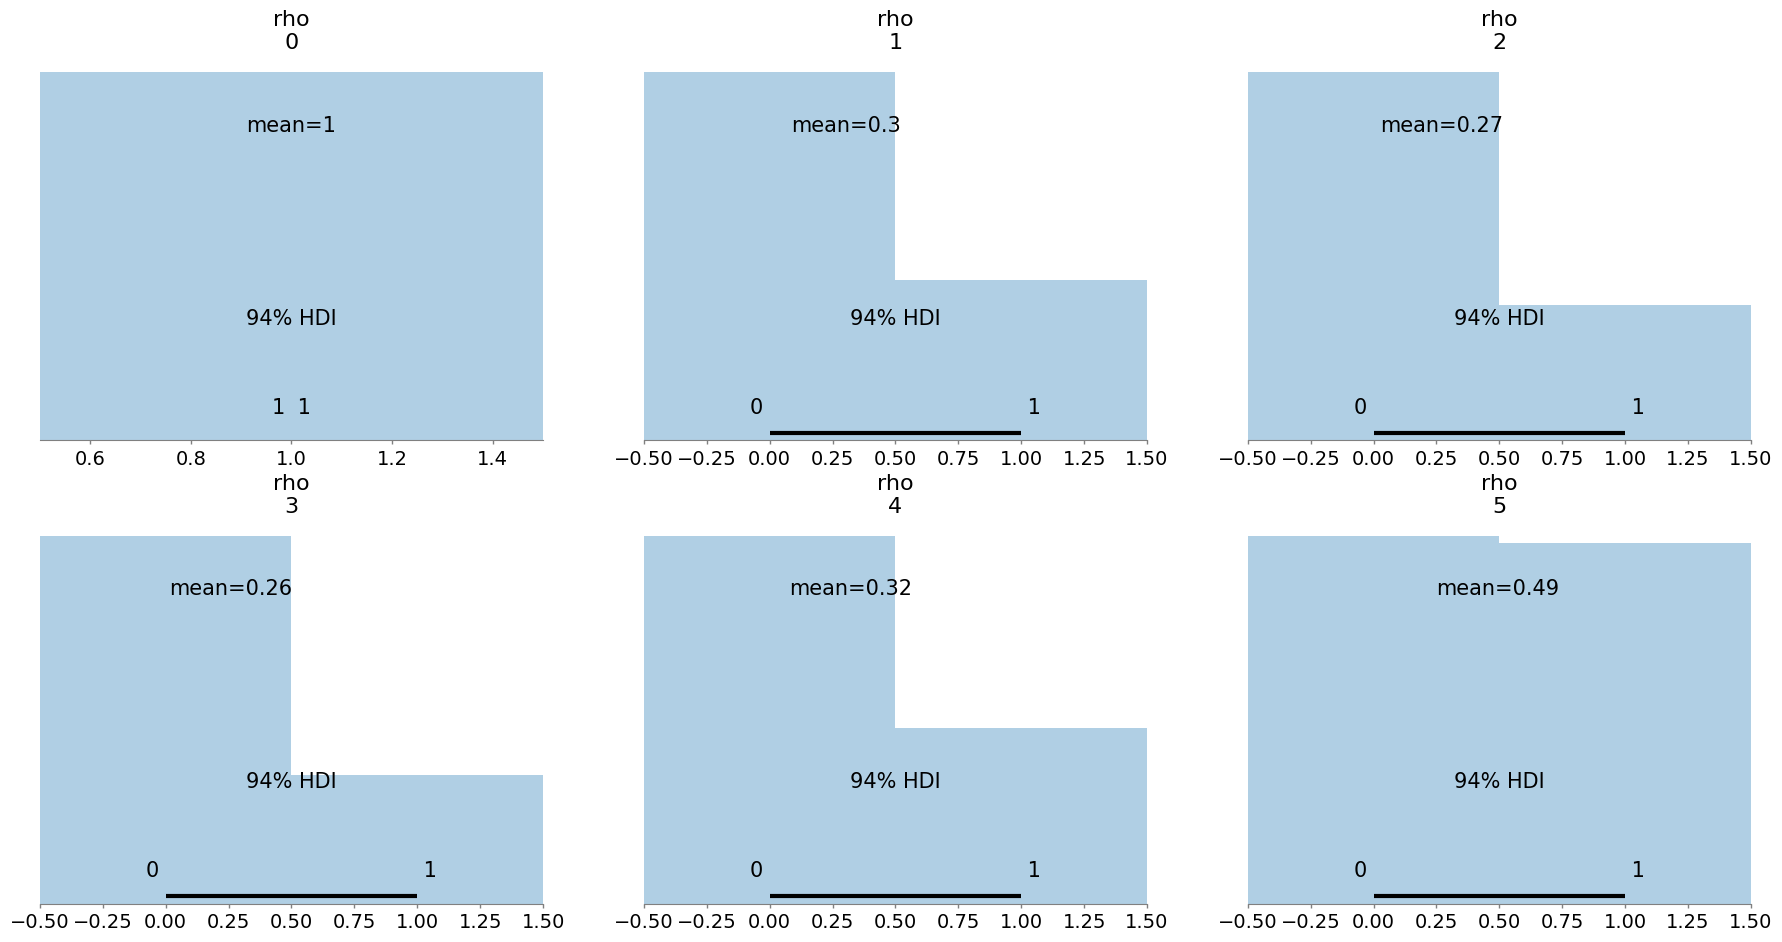

In [8]:
az.plot_posterior(idata, var_names=["rho"], show=True);

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


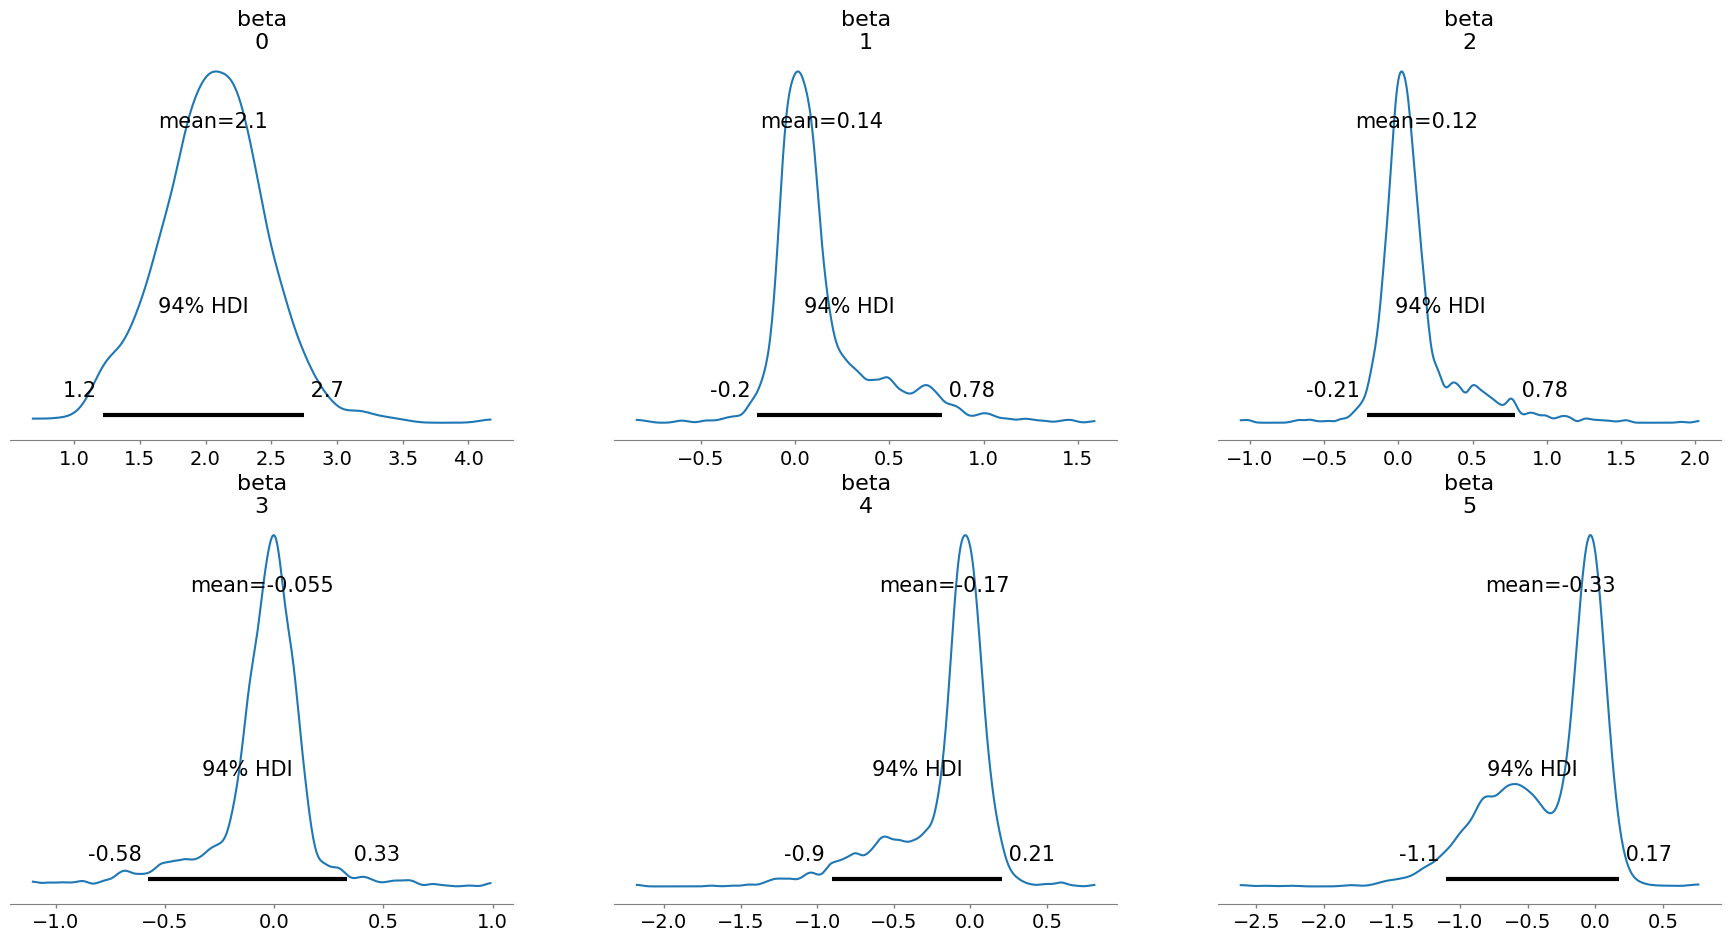

In [9]:
az.plot_posterior(idata, var_names=["beta"], show=True);

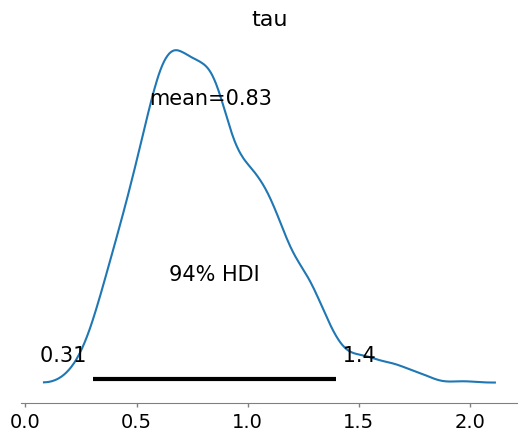

In [10]:
az.plot_posterior(idata, var_names=["tau"], show=True);

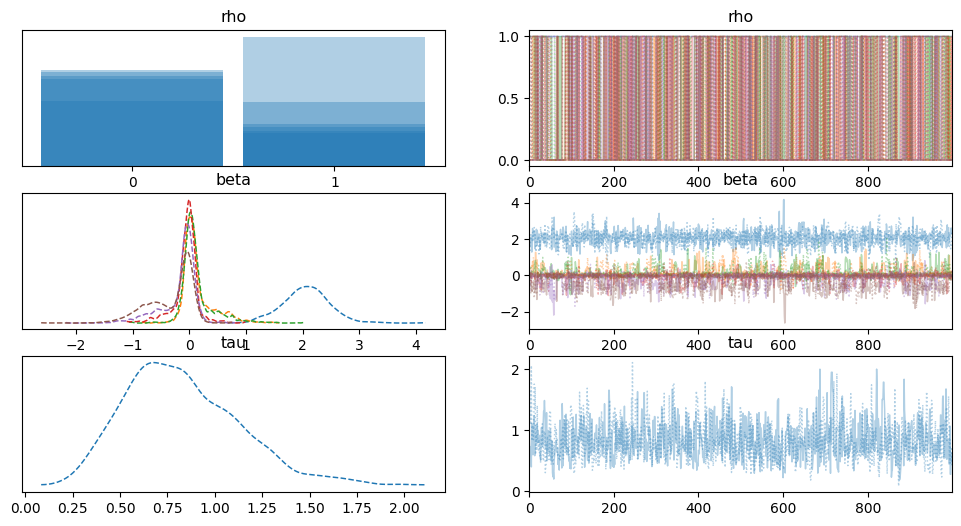

In [11]:
az.plot_trace(idata, combined=True);

In [12]:
az.summary(idata)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho[0],1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
rho[1],0.304,0.460,0.000,1.000,0.024,0.017,367.0,367.0,1.00
rho[2],0.269,0.444,0.000,1.000,0.021,0.015,436.0,436.0,1.00
rho[3],0.260,0.438,0.000,1.000,0.019,0.014,511.0,511.0,1.00
rho[4],0.324,0.468,0.000,1.000,0.024,0.017,367.0,367.0,1.02
rho[5],0.495,0.500,0.000,1.000,0.033,0.023,230.0,230.0,1.00
beta[0],2.055,0.409,1.216,2.750,0.011,0.008,1311.0,824.0,1.00
beta[1],0.142,0.279,-0.202,0.781,0.014,0.010,516.0,666.0,1.00
beta[2],0.122,0.283,-0.214,0.783,0.011,0.008,860.0,781.0,1.00
beta[3],-0.055,0.223,-0.578,0.332,0.009,0.007,836.0,647.0,1.00


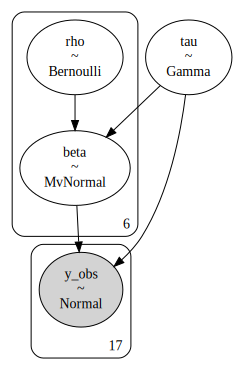

In [13]:
pm.model_to_graphviz(model)

In [14]:
df_idata = idata.to_dataframe()
df_idata

,chain,draw,"(posterior, rho[0], 0)","(posterior, rho[1], 1)","(posterior, rho[2], 2)","(posterior, rho[3], 3)","(posterior, rho[4], 4)","(posterior, rho[5], 5)","(posterior, beta[0], 0)","(posterior, beta[1], 1)",...,"(sample_stats, acceptance_rate)","(sample_stats, energy_error)","(sample_stats, step_size_bar)","(sample_stats, index_in_trajectory)","(sample_stats, max_energy_error)","(sample_stats, process_time_diff)","(sample_stats, lp)","(sample_stats, perf_counter_diff)","(sample_stats, step_size)","(sample_stats, diverging)"
0,0,0,1,0,0,0,0,1,2.128610,0.105734,...,0.958962,0.096158,0.319350,2,0.217644,0.054865,-34.098766,0.046863,0.270259,False
1,0,1,1,0,0,0,0,1,2.146266,-0.050441,...,0.870665,-0.029189,0.319350,2,0.345202,0.071667,-34.228824,0.060249,0.270259,False
2,0,2,1,0,0,0,0,1,1.907736,0.103452,...,0.885215,0.278488,0.319350,-2,0.404122,0.110921,-36.403875,0.089378,0.270259,False
3,0,3,1,0,0,0,0,1,1.635089,-0.070802,...,1.000000,-0.015641,0.319350,-3,-0.500443,0.039151,-35.503090,0.039161,0.270259,False
4,0,4,1,0,0,0,0,1,2.043036,-0.015672,...,0.953825,-0.280122,0.319350,-6,-0.765203,0.090277,-35.388032,0.070827,0.270259,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,995,1,1,1,0,0,0,1.848478,0.238397,...,0.403139,1.096943,0.304515,6,1.690777,0.014978,-38.909616,0.007489,0.282523,False
1996,1,996,1,0,0,0,0,0,1.464577,-0.214500,...,1.000000,-0.512282,0.304515,4,-1.199452,0.016292,-39.024291,0.008152,0.282523,False
1997,1,997,1,0,0,0,0,0,1.650616,0.088884,...,1.000000,-0.455615,0.304515,2,-0.455615,0.010494,-34.888340,0.005256,0.282523,False
1998,1,998,1,0,0,1,0,0,1.799427,0.026934,...,0.980700,0.158199,0.304515,-3,-0.577804,0.069655,-37.379388,0.034830,0.282523,False


In [15]:
df_idata_renamed = df_idata.copy()
for i in range(0,6):
  df_idata_renamed = df_idata_renamed.rename(columns={("posterior", f"rho[{i}]", i): f"post_rho_{i+1}",
                   ("posterior", f"beta[{i}]", i): f"post_beta_{i+1}",
                   })

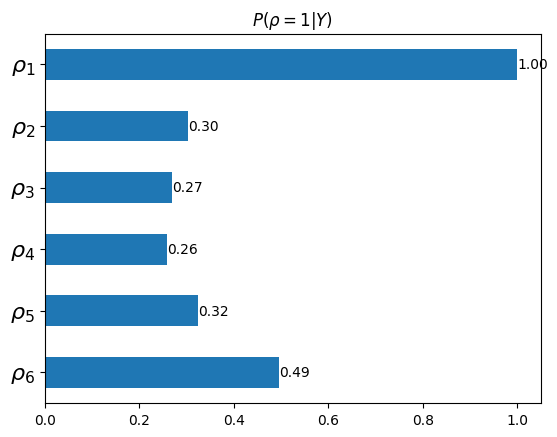

In [16]:
ax = df_idata_renamed[["post_rho_1", "post_rho_2", "post_rho_3", "post_rho_4", "post_rho_5", "post_rho_6"]].mean().sort_index(ascending=False).plot.barh()

ax.set_yticks([0,1,2,3,4,5], labels=['$\\rho_6$', '$\\rho_5$', '$\\rho_4$', '$\\rho_3$', '$\\rho_2$', '$\\rho_1$'], fontsize=16);
ax.set_title('$P(\\rho=1|Y)$')
for c in ax.containers:
  ax.bar_label(c, fmt="%.2f")

In [17]:
for i in range(1, 7):
  df_idata_renamed[f'$\\beta_{i}$'] = df_idata_renamed.loc[df_idata_renamed[f"post_rho_{i}"]==1, f"post_beta_{i}"]

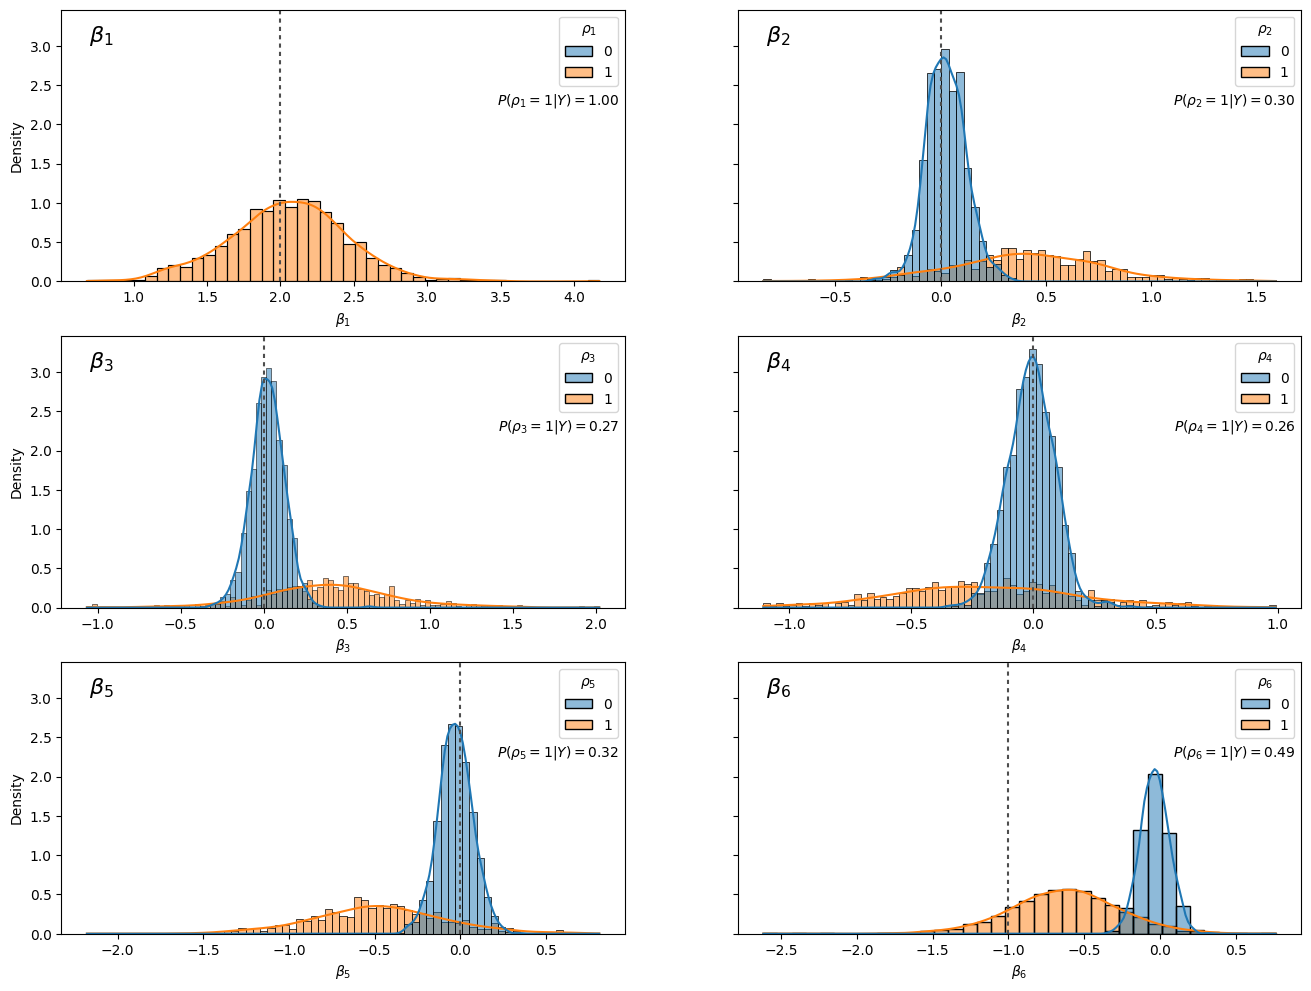

In [18]:
post_prob_rho = df_idata_renamed.filter(like="post_rho").mean()

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(16,12))

for i, ax in enumerate(axes.flatten()):
  sns.histplot(data=df_idata_renamed, x=f"post_beta_{i+1}", hue=f"post_rho_{i+1}", kde=True, hue_order=[0,1], stat="density", ax=ax)
  ax.axvline(true_beta[i], color=".3", dashes=(2, 2))
  ax.set_xlabel(f'$\\beta_{i+1}$')
  #ax.set_ylabel('$P(\\beta_k \\vert Y, \\rho_k) P(\\rho_k \\vert Y)$')
  ax.get_legend().set_title(f'$\\rho_{i+1}$')
  ax.text(0.99,0.70, f'$P(\\rho_{i+1}=1 \\vert Y) ={post_prob_rho[i]:.2f}$', ha="right", va="top", transform=ax.transAxes, fontsize=10)
  ax.text(0.05,0.95, f'$\\beta_{i+1}$', ha="left", va="top", transform=ax.transAxes, fontsize=16)

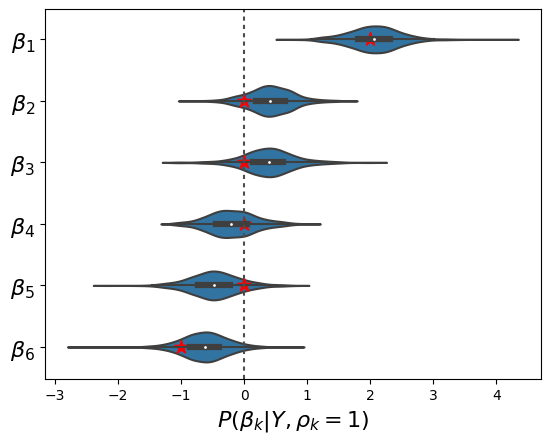

In [19]:
ax = sns.violinplot(y="level_0", x=0, data=df_idata_renamed.filter(like="\\beta").unstack().reset_index(), whis=(2.5, 97.5), width=0.5, color="tab:blue")
ax.axvline(0, color=".3", dashes=(2, 2))
ax.scatter(x=true_beta, y=(0, 1, 2, 3, 4, 5), color="red", marker="*", s=100)
ax.set_xlabel('$P(\\beta_k \\vert Y, \\rho_k=1)$', fontsize=16)
ax.set_ylabel(None)
ax.yaxis.set_tick_params(labelsize=16)

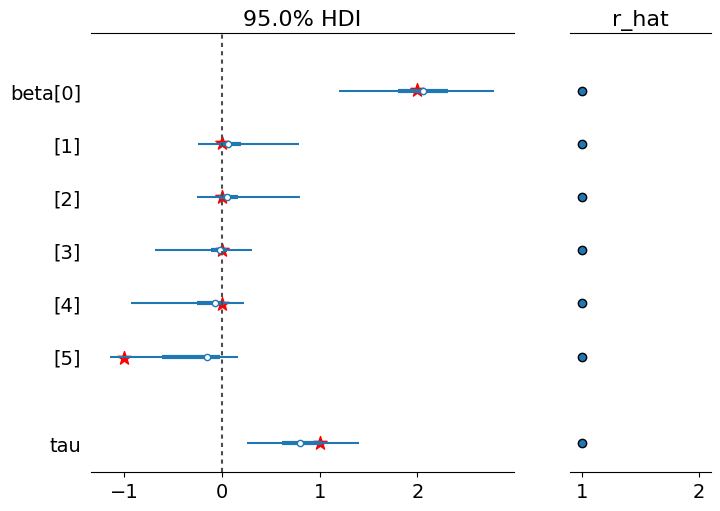

In [20]:
axes = az.plot_forest(idata, var_names=["beta", "tau"], combined=True, hdi_prob=0.95, r_hat=True)
ax = axes[0]
ax.axvline(0, color=".3", dashes=(2, 2))
ax.scatter(x=true_beta, y=(16.5, 14, 11.5, 9, 6.5, 4), color="red", marker="*", s=100)
ax.scatter(x=(1), y=(0), color="red", marker="*", s=100)

## 事後予測値の可視化

In [21]:
x_sample_des = generate_design_matrix(x_sample)

In [22]:
idata.posterior["rho"].to_numpy().shape

(2, 1000, 6)

In [23]:
idata.posterior["rho"].to_numpy().mean(1)

array([[1.   , 0.297, 0.257, 0.251, 0.357, 0.514],
       [1.   , 0.311, 0.281, 0.268, 0.291, 0.476]])

In [24]:
(idata.posterior["beta"].to_numpy() * idata.posterior["rho"].to_numpy()).shape

(2, 1000, 6)

In [25]:
#y_model = ((idata.posterior["beta"].to_numpy() * idata.posterior["rho"].to_numpy()) @ x_sample_des.T)
y_model = idata.posterior["beta"].to_numpy()  @ x_sample_des.T

In [26]:
y_model.shape

(2, 1000, 101)

In [27]:
x_sample.repeat(2000).reshape(101,2000).T

array([[0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       ...,
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ]])

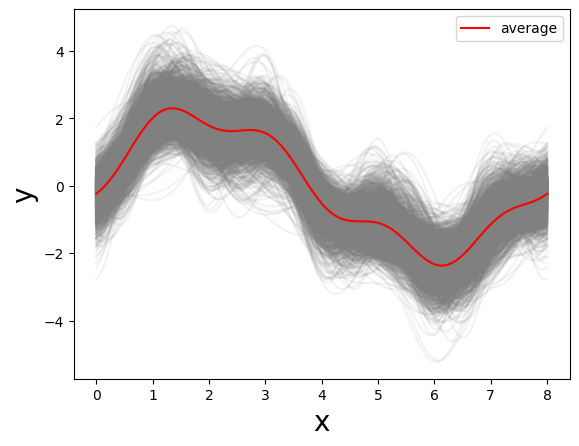

In [28]:
fig, ax = plt.subplots()
ax.plot(x_sample.repeat(2000).reshape(-1,2000), y_model.reshape(2000,-1).T, color="gray", alpha=0.1);
ax.plot(x_sample, y_model.reshape(2000, -1).mean(0), color="red", label="average");
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("y", fontsize=20)
ax.legend(loc="best")

In [29]:
y_lower, y_upper = np.percentile(y_model.reshape(2000,-1), q=[2.5,97.5], axis=0)

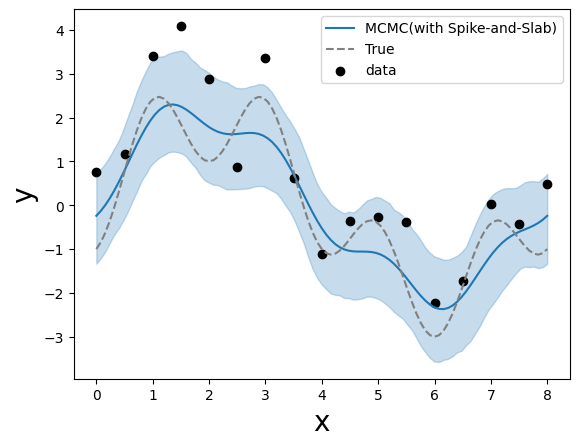

In [30]:
fig, ax = plt.subplots()

ax.plot(x_sample, y_model.reshape(2000, -1).mean(0), label="MCMC(with Spike-and-Slab)");
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.fill_between(x_sample, y_lower, y_upper, alpha=0.25, color='tab:blue')
ax.scatter(x, y, label="data", color="black")
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("y", fontsize=20)
ax.legend(loc="best")

# Spike-and-Slab 事前分布を用いないベイズ線形回帰モデル

In [31]:
def get_linear_model(y, X):
    model = pm.Model()

    Sigma = 0.5 * np.matmul(X.T, X) / y.shape[0]
    Sigma += np.diag(np.diag(Sigma))
    #Sigma = np.linalg.inv(Sigma)

    s_y2 = np.var(y, ddof=1)

    nu = 0.01
    R2 = 0.5
    s = nu * (1 - R2) * s_y2

    with model:
        tau = pm.Gamma('tau', nu/2, s/2)
        beta = pm.MvNormal('beta', 0, tau=tau * Sigma, shape=X.shape[1])
        mean = pm.math.dot(X, beta)
        y_obs = pm.Normal('y_obs', mean, tau=tau, observed=y)
    return model

In [32]:
linear_model = get_linear_model(y, x_des)

In [33]:
with linear_model:
    # draw 1000 posterior samples
    idata_linear = pm.sample()

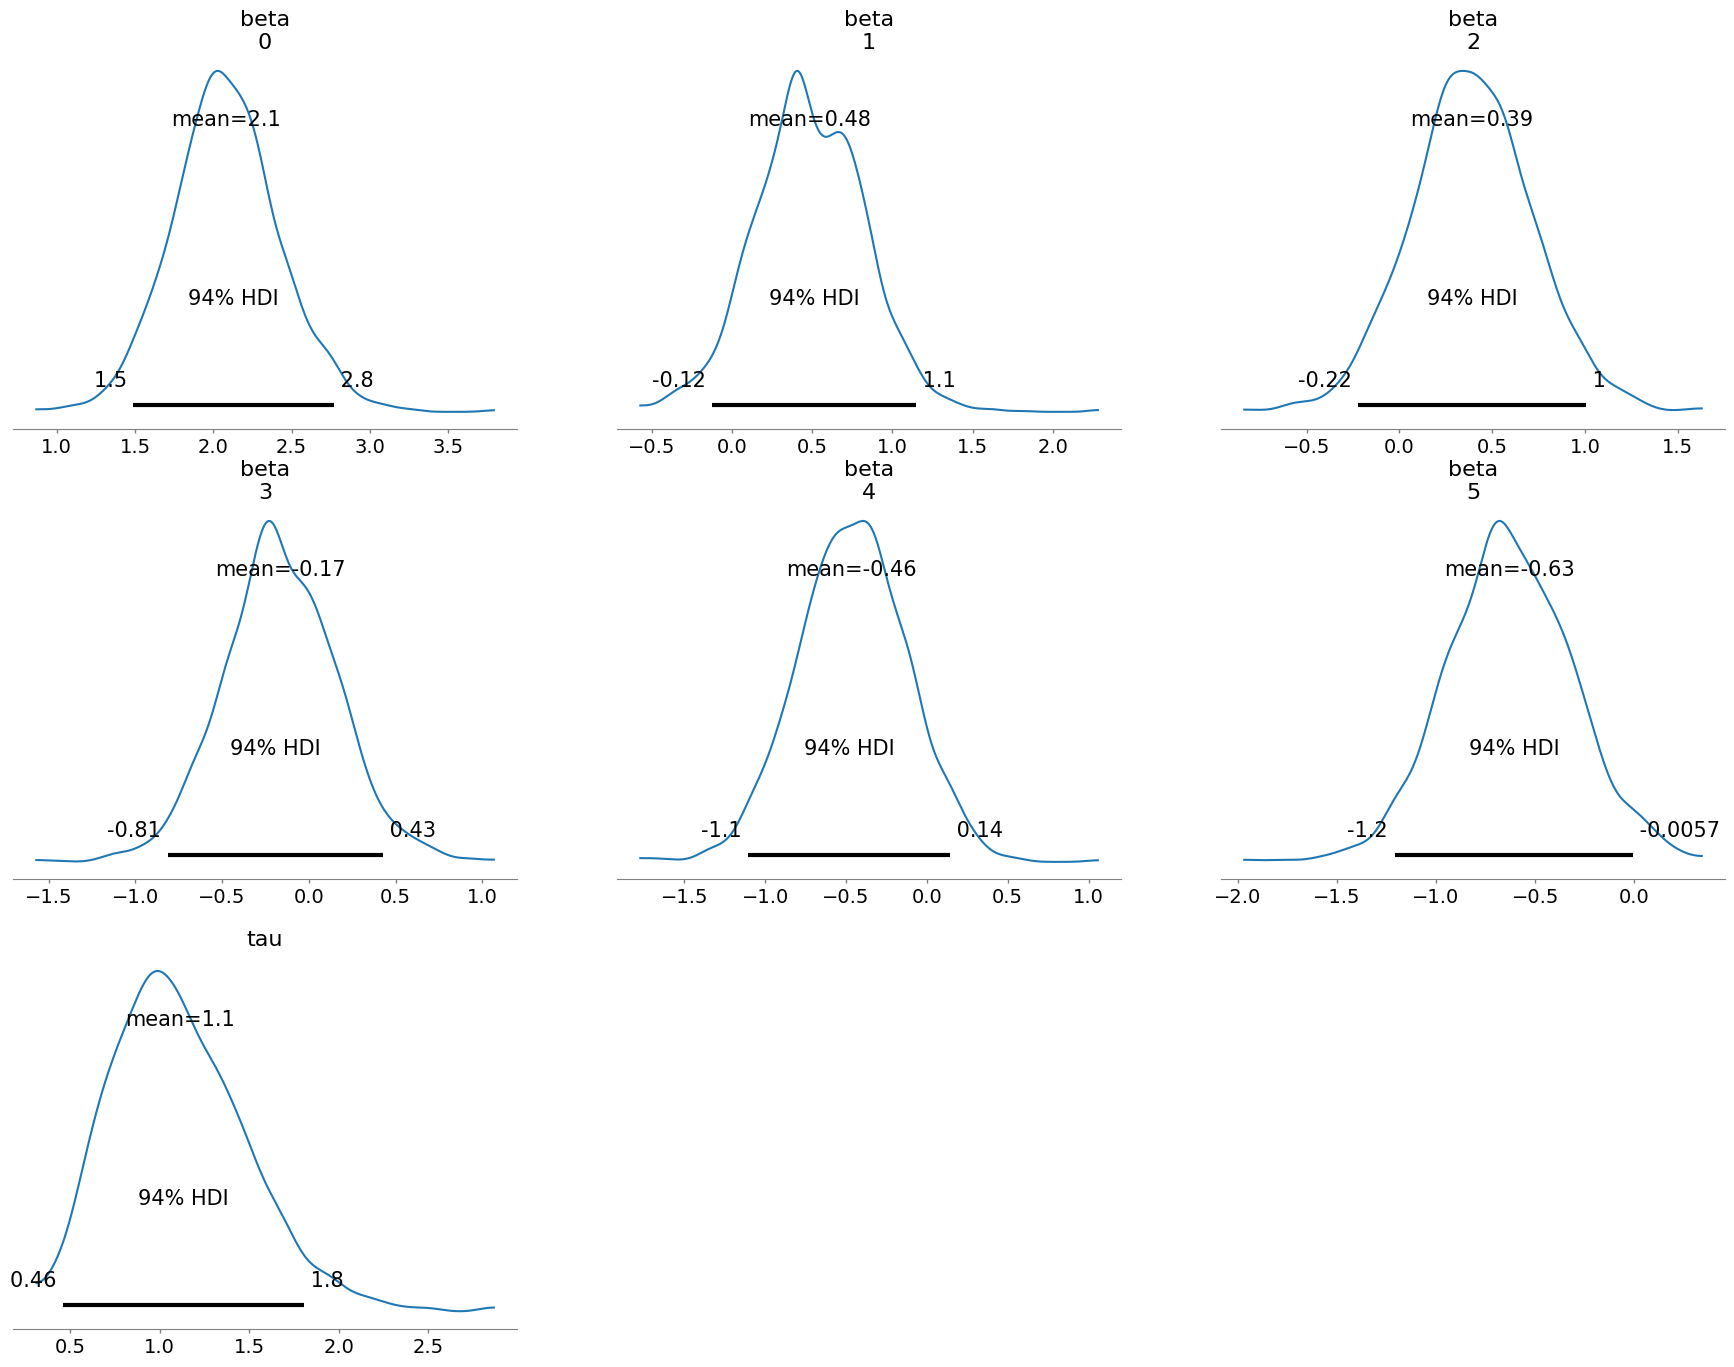

In [34]:
az.plot_posterior(idata_linear, show=True);

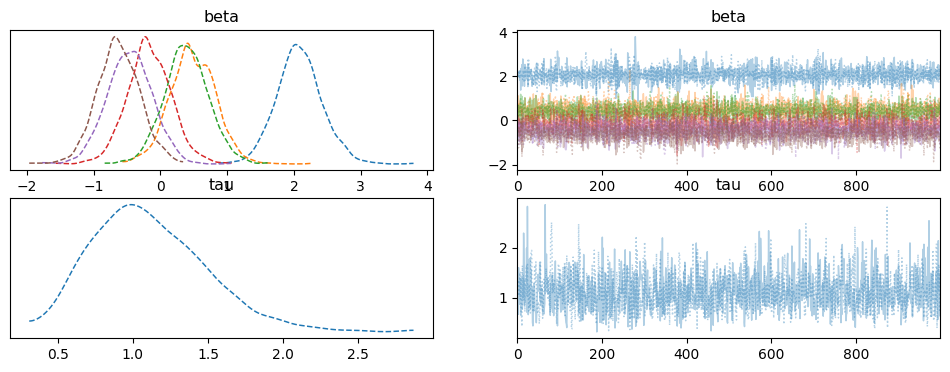

In [35]:
az.plot_trace(idata_linear, combined=True);

In [36]:
az.summary(idata_linear)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.082,0.341,1.490,2.772,0.006,0.005,2925.0,1293.0,1.00
beta[1],0.484,0.340,-0.122,1.144,0.006,0.005,2948.0,1406.0,1.00
beta[2],0.389,0.330,-0.223,1.005,0.006,0.006,2594.0,1343.0,1.01
beta[3],-0.167,0.331,-0.813,0.430,0.006,0.006,3131.0,1578.0,1.00
beta[4],-0.464,0.337,-1.108,0.144,0.006,0.005,3161.0,1746.0,1.00
beta[5],-0.630,0.319,-1.208,-0.006,0.007,0.005,2427.0,1437.0,1.00
tau,1.111,0.379,0.459,1.804,0.010,0.007,1410.0,1438.0,1.00


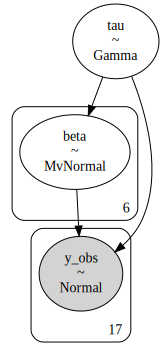

In [37]:
pm.model_to_graphviz(linear_model)

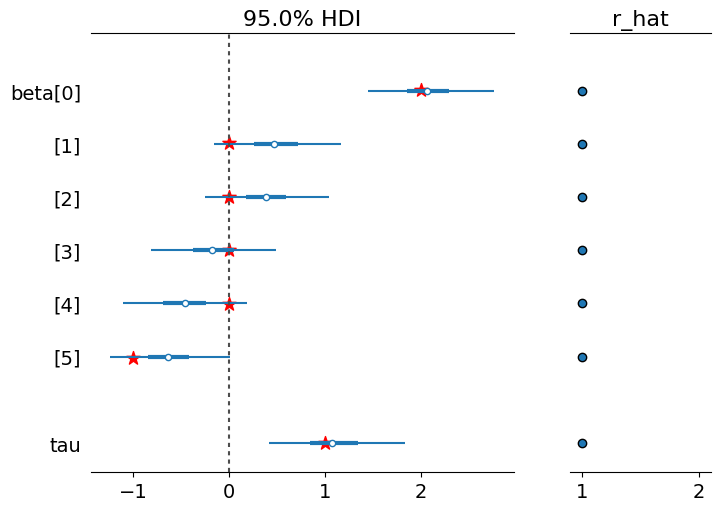

In [38]:
axes = az.plot_forest(idata_linear, var_names=["beta", "tau"], combined=True, hdi_prob=0.95, r_hat=True)
ax = axes[0]
ax.axvline(0, color=".3", dashes=(2, 2))
ax.scatter(x=true_beta, y=(16.5, 14, 11.5, 9, 6.5, 4), color="red", marker="*", s=100)
ax.scatter(x=(1), y=(0), color="red", marker="*", s=100)

In [39]:
y_linear_model = (idata_linear.posterior["beta"].to_numpy() @ x_sample_des.T)

In [40]:
y_linear_model.shape

(2, 1000, 101)

In [41]:
x_sample.repeat(2000).reshape(101,2000).T

array([[0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       ...,
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ],
       [0.  , 0.08, 0.16, ..., 7.84, 7.92, 8.  ]])

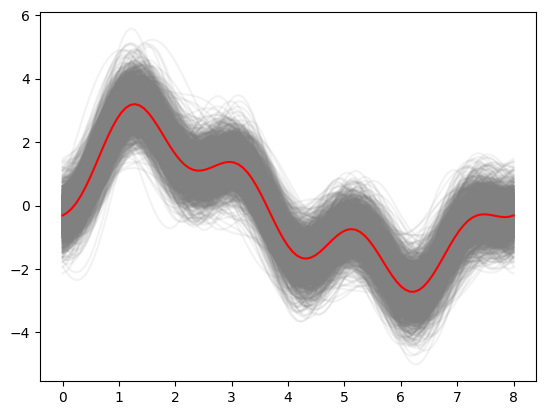

In [42]:
plt.plot(x_sample.repeat(2000).reshape(-1,2000), y_linear_model.reshape(2000,-1).T, color="gray", alpha=0.1);
plt.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), color="red");

In [43]:
y_lower_linear, y_upper_linear = np.percentile(y_linear_model.reshape(2000,-1), q=[2.5,97.5], axis=0)

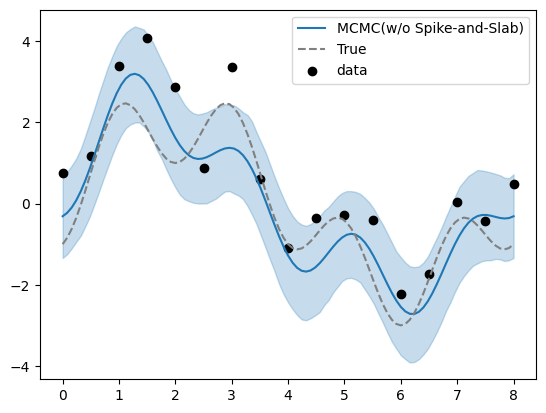

In [44]:
fig, ax = plt.subplots()

ax.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), label="MCMC(w/o Spike-and-Slab)");
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.fill_between(x_sample, y_lower_linear, y_upper_linear, alpha=0.25, color='tab:blue')
ax.scatter(x, y, label="data", color="black")
ax.legend(loc="best")

# ベイズを使わず最小二乗法でやってみる

In [45]:
import statsmodels.api as sm

In [46]:
sm.__version__

'0.14.1'

In [47]:
mod = sm.OLS(y, x_des)

In [48]:
res = mod.fit()

In [49]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.790
Model:                            OLS   Adj. R-squared (uncentered):              0.676
Method:                 Least Squares   F-statistic:                              6.909
Date:                Sun, 07 Jan 2024   Prob (F-statistic):                     0.00307
Time:                        03:37:00   Log-Likelihood:                         -21.683
No. Observations:                  17   AIC:                                      55.37
Df Residuals:                      11   BIC:                                      60.37
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


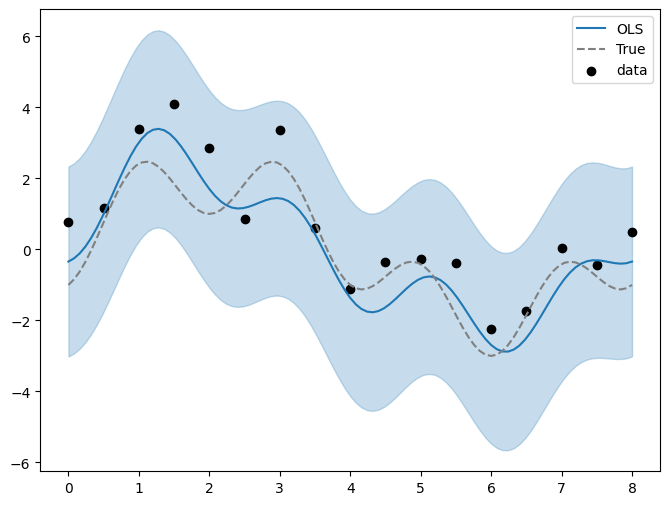

In [50]:
pred_ols = res.get_prediction(exog=x_sample_des)
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_sample, pred_ols.predicted, label="OLS");
ax.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax.fill_between(x_sample, iv_l, iv_u, alpha=0.25, color='tab:blue')
ax.scatter(x, y, label="data", color="black")
ax.legend(loc="best")

# Spike-and-Slab あり・なしの結果を並べる

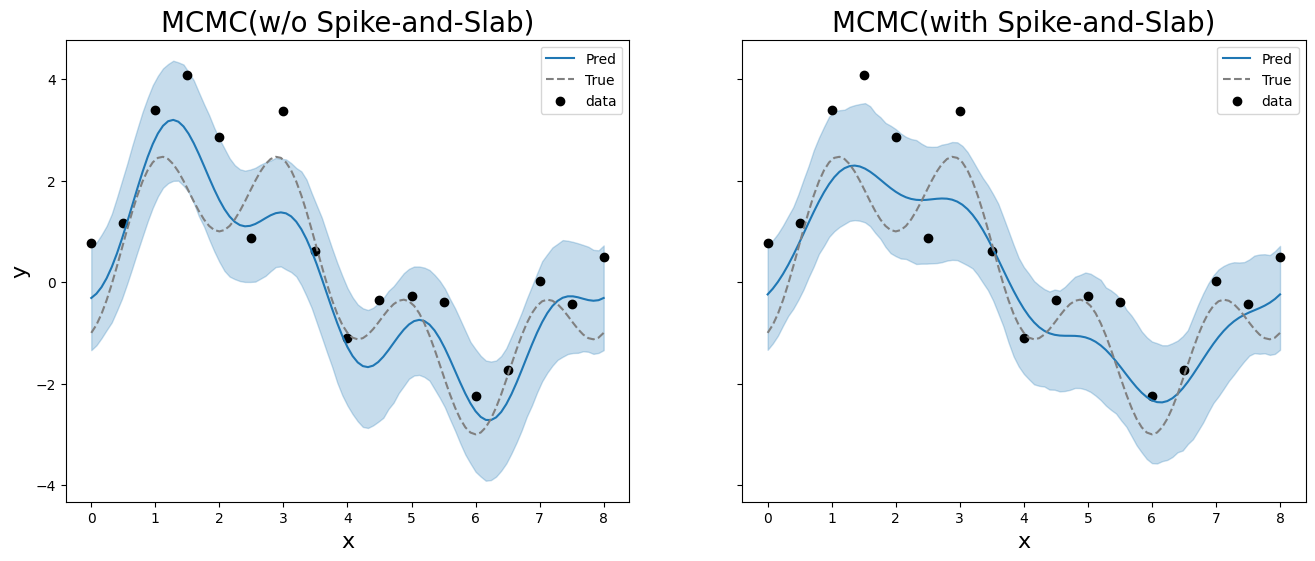

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,6))

ax1, ax2 = axes.flatten()

ax1.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), label="Pred");
ax1.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax1.fill_between(x_sample, y_lower_linear, y_upper_linear, alpha=0.25, color='tab:blue')
ax1.scatter(x, y, label="data", color="black")
ax1.set_title("MCMC(w/o Spike-and-Slab)", fontsize=20)
ax1.set_xlabel("x", fontsize=16)
ax1.set_ylabel("y", fontsize=16)
ax1.legend(loc="best")

ax2.plot(x_sample, y_model.reshape(2000, -1).mean(0), label="Pred");
ax2.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax2.fill_between(x_sample, y_lower, y_upper, alpha=0.25, color='tab:blue')
ax2.scatter(x, y, label="data", color="black")
ax2.set_title("MCMC(with Spike-and-Slab)", fontsize=20)
ax2.set_xlabel("x", fontsize=16)
ax2.legend(loc="best")



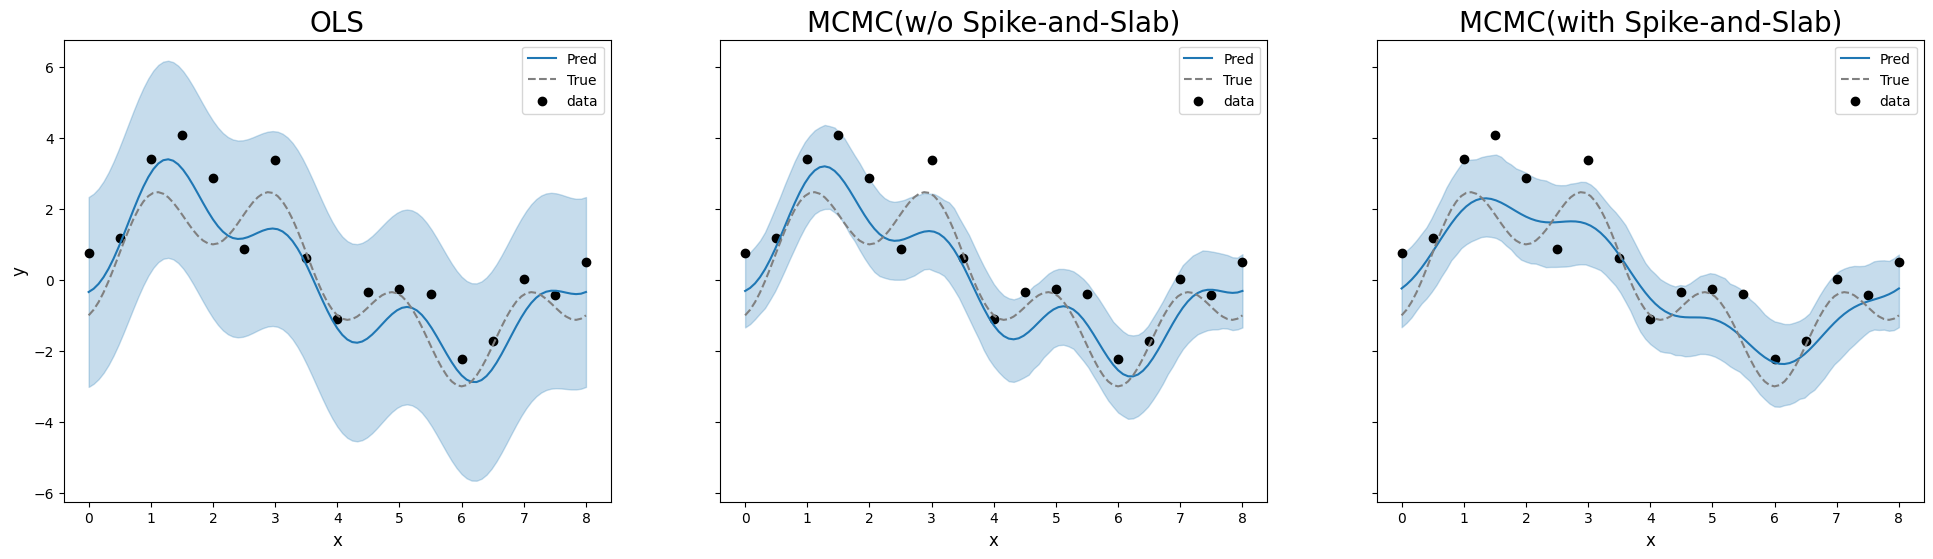

In [52]:
# 参考・最小二乗法の結果も並べて表示
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24,6))

ax0, ax1, ax2 = axes.flatten()

ax0.plot(x_sample, pred_ols.predicted, label="Pred");
ax0.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax0.fill_between(x_sample, iv_l, iv_u, alpha=0.25, color='tab:blue')
ax0.scatter(x, y, label="data", color="black")
ax0.set_title("OLS", fontsize=20)
ax0.set_xlabel("x", fontsize=12)
ax0.set_ylabel("y", fontsize=12)
ax0.legend(loc="best")

ax1.plot(x_sample, y_linear_model.reshape(2000, -1).mean(0), label="Pred");
ax1.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax1.fill_between(x_sample, y_lower_linear, y_upper_linear, alpha=0.25, color='tab:blue')
ax1.scatter(x, y, label="data", color="black")
ax1.set_title("MCMC(w/o Spike-and-Slab)", fontsize=20)
ax1.set_xlabel("x", fontsize=12)
ax1.legend(loc="best")

ax2.plot(x_sample, y_model.reshape(2000, -1).mean(0), label="Pred");
ax2.plot(x_sample, y_org_sample, color="gray", linestyle="dashed", label="True")
ax2.fill_between(x_sample, y_lower, y_upper, alpha=0.25, color='tab:blue')
ax2.scatter(x, y, label="data", color="black")
ax2.set_title("MCMC(with Spike-and-Slab)", fontsize=20)
ax2.set_xlabel("x", fontsize=12)
ax2.legend(loc="best")



Text(0.5, 1.0, '95.0% HDI (with Spike-and-Slab Prior)')

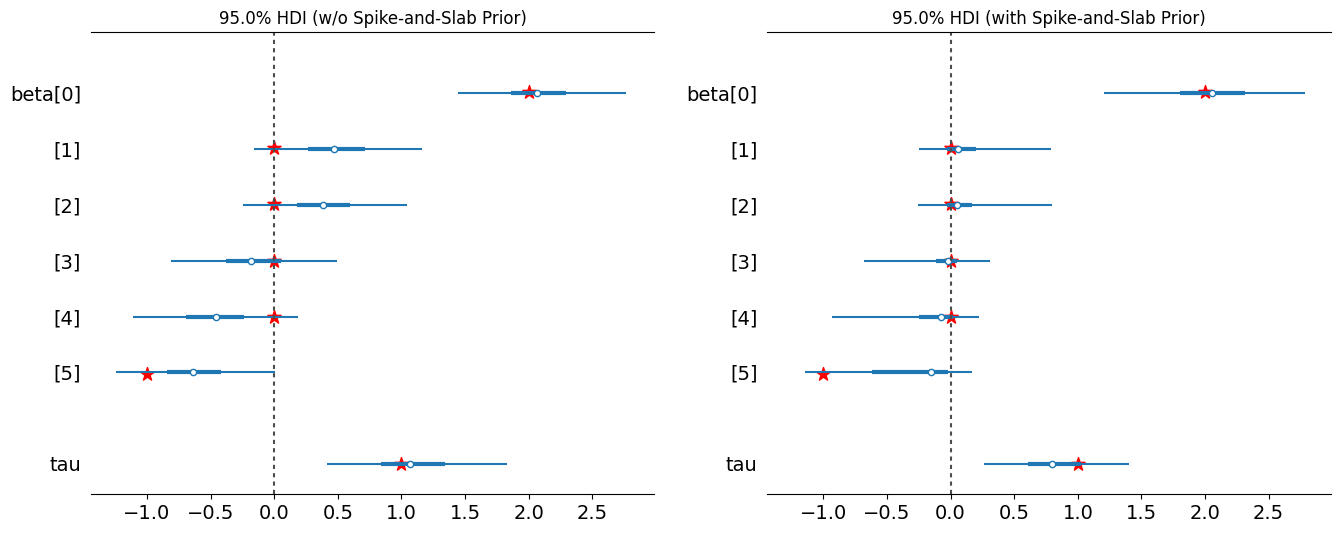

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=True, figsize=(16,6))

az.plot_forest(idata_linear, var_names=["beta", "tau"], combined=True, hdi_prob=0.95, ax=ax1)
ax1.axvline(0, color=".3", dashes=(2, 2))
ax1.scatter(x=true_beta, y=(16.5, 14, 11.5, 9, 6.5, 4), color="red", marker="*", s=100)
ax1.scatter(x=(1), y=(0), color="red", marker="*", s=100)
ax1.set_title("95.0% HDI (w/o Spike-and-Slab Prior)")

az.plot_forest(idata, var_names=["beta", "tau"], combined=True, hdi_prob=0.95, ax=ax2)
ax2.axvline(0, color=".3", dashes=(2, 2))
ax2.scatter(x=true_beta, y=(16.5, 14, 11.5, 9, 6.5, 4), color="red", marker="*", s=100)
ax2.scatter(x=(1), y=(0), color="red", marker="*", s=100)
ax2.set_title("95.0% HDI (with Spike-and-Slab Prior)")